In [4]:
%run controlled-u-gate.ipynb

done
done


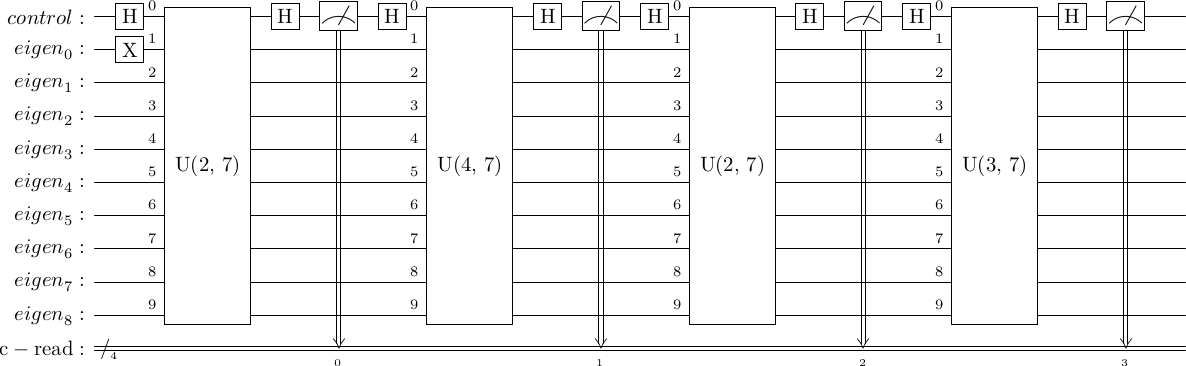

In [5]:
def shors_circuit(a, N, precision):
    assert a <= N
    
    """ Initialization"""
    N_bits = floor(log(N, 2)) + 1
    word_size = N_bits + 1
    c_reg = QuantumRegister(1, name="control")
    eig_reg = QuantumRegister(2 * word_size + 1, name="eigen")
    c_read_reg = ClassicalRegister(precision, name="c-read")
    #out_reg = ClassicalRegister(N_bits, "out")
    shors_circ = QuantumCircuit(c_reg, eig_reg, c_read_reg)
    shors_circ.x(eig_reg[0])
    
    """ Construction """
    cum_phase = 0
    for i in range(precision):
        # hadamard (initiation)
        shors_circ.h(c_reg[0])
        # c-U gate application
        controlled_U = c_U(
            (a**(2**(precision - i - 1))) % N,
            N,
            word_size
        ).to_gate(label=f"U({(a**(2**(precision - i - 1))) % N}, {N})")
        shors_circ.append(controlled_U, range(1 + 2 * word_size + 1))
        #rotations (iqft) (depend on measurement outcome so far)
        if i >= 1:
            if c_read_reg[i-1] == 1:
                #not in use (but it would be better to apply cumulative phase in single gate)
                cum_phase -= 2 * pi / (2**(i+1)) 
                shors_circ.p(cum_phase , c_reg[0])
            #for j in range(1, i+1):
                #shors_circ.p(-2 * pi / (2**(j+1)) , c_reg[0]).c_if(c_read_reg[j-1], 1)
        #hadamard (iqft)
        shors_circ.h(c_reg[0])
        #measurement
        shors_circ.measure(c_reg[0], c_read_reg[i])
    return shors_circ

shors_circuit(3, 7, 4).draw("latex")

In [20]:
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile


a = 7
N = 15

N_bits = floor(log(N, 2)) + 1
word_size = N_bits + 1
precision = 2 * word_size + 1
precision = 4
""" Simulation """
# Create a simulator
simulator = QasmSimulator()
# Compile the circuit for the simulator
compiled_circuit = transpile(shors_circuit(a, N, precision), simulator)
# Simulate the circuit
simulation = simulator.run(compiled_circuit, shots=100)
# Get the simulation results
simulation_result = simulation.result()
counts = simulation_result.get_counts(compiled_circuit)

In [21]:
phases = list(counts.items())
phases.sort(reverse=True, key=lambda a : a[1])
top_phases = phases[:]
top_phases

[('0100', 31), ('0000', 26), ('1000', 24), ('1100', 19)]

In [22]:
from fractions import Fraction
fracs = []
for phase in top_phases:
    decimal = int(phase[0], 2)/(2**precision)
    fracs += [Fraction(decimal).limit_denominator(N)]
fracs

[Fraction(1, 4), Fraction(0, 1), Fraction(1, 2), Fraction(3, 4)]

In [24]:
a**4 % N

1